<a href="https://colab.research.google.com/github/amien1410/kaggle-projects/blob/main/Rice_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install Kaggle Modules to download the dataset
!pip install kaggle

# Load Kaggle user authorization key
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

# Download the dataset, get the user and dataset name from the url "https://www.kaggle.com/datasets/shivamb/netflix-shows"
!kaggle datasets download -d muratkokludataset/rice-image-dataset

# Unzip the dataset
!unzip -q "/content/rice-image-dataset"

# Source - https://www.kaggle.com/code/ayessa/rice-classification-99-accuracy

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 95% 209M/219M [00:02<00:00, 83.7MB/s]
100% 219M/219M [00:02<00:00, 100MB/s] 


In [2]:
#@title Building Deep Learning Model
import tensorflow as tf
from tensorflow import keras
# For accessing pre-trained models
import tensorflow_hub as hub
# For separating train and test sets
from sklearn.model_selection import train_test_split

# For visualizations
import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL.Image as Image
import cv2

import os
import numpy as np
import pathlib

In [3]:
data_dir = "/content/Rice_Image_Dataset" # Datasets path
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/Rice_Image_Dataset')

In [4]:
#@title Separating the Categories
arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

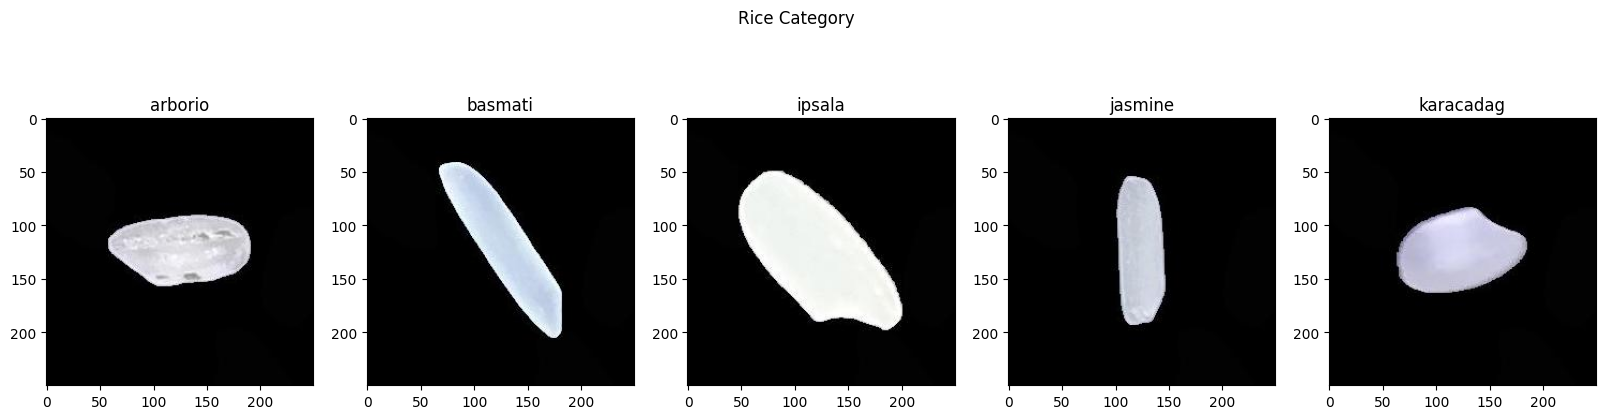

In [6]:
# Checking Samples

fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category')
arborio_image = img.imread(arborio[0])
basmati_image = img.imread(basmati[0])
ipsala_image = img.imread(ipsala[0])
jasmine_image = img.imread(jasmine[0])
karacadag_image = img.imread(karacadag[0])

ax[0].set_title('arborio')
ax[1].set_title('basmati')
ax[2].set_title('ipsala')
ax[3].set_title('jasmine')
ax[4].set_title('karacadag')


ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)

In [7]:
#@title Assigning a separate dictionary for images and their corresponding labels

# Contains the images path
df_images = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}

# Contains numerical labels for the categories
df_labels = {
    'arborio' : 0,
    'basmati' : 1,
    'ipsala' : 2,
    'jasmine' : 3,
    'karacadag': 4
}

In [8]:
#@title Since the MobileNetv2 training images dimensions are 224 by 224 by 3, we have to reshape our categories into that

img = cv2.imread(str(df_images['arborio'][0])) # Converting it into numerical arrays
print(img.shape)

X, y = [], [] # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on MobileNetv2 model
        X.append(resized_img)
        y.append(df_labels[label])

(250, 250, 3)


In [9]:
#@title Splitting the data and standarization

# Standarizing
X = np.array(X)
X = X/255
y = np.array(y)

# Separating data into training, test and validation sets
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

In [32]:
mobile_net = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4' # MobileNetv4 link
mobile_net = hub.KerasLayer(
        mobile_net, input_shape=(224,224, 3), trainable=False) # Removing the last layer

In [33]:
import tf_keras as keras

num_label = 5 # number of labels

model = keras.Sequential([
    mobile_net,
    keras.layers.Dense(num_label)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_10 (KerasLayer  (None, 1280)              2257984   
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
#@title Training the Model
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))